# Обучение GNN-модели на датасете графов

In [1]:
%load_ext autoreload
%autoreload 2

from src.data.hydrodataset import HydroDataset

import torch
torch.autograd.set_detect_anomaly(True)

from src.models.gnnprocessor import GNNProcessor
from src.visualization.visualize import visualize_graph
from src.models.train_model import HydraulicsLoss

from torch_geometric.nn import summary
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt

In [2]:
dataset = HydroDataset(root="/tmp/hydro")
train_ds = dataset
print("Dataset length:", len(train_ds))

Dataset length: 2


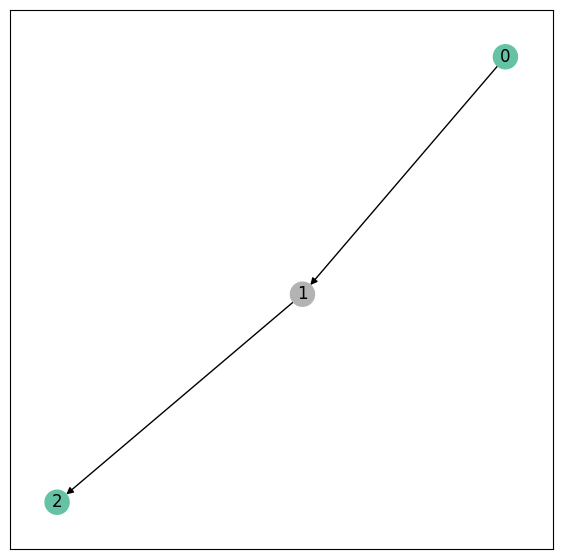

In [3]:
G = to_networkx(dataset[0], to_undirected=False)
visualize_graph(G, color=dataset[0].x[..., 1] == 0);


In [4]:
loader = DataLoader(train_ds, batch_size=32)

In [5]:
model = GNNProcessor(out_channels=1, num_edge_features=dataset.num_edge_features, latent_dim=10, num_convs=20)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)

GNNProcessor(
  (convs): ModuleList(
    (0-19): 20 x GNNSConv(aggr=mean, latent_dim=10)
  )
  (final): Linear(in_features=10, out_features=1, bias=True)
  (balance_conv): BalanceConv()
)


In [6]:
criterion = HydraulicsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

losses = []
def train():
  model.train()

  total_loss = 0
  for data in loader:
    data = data.to(device)
    optimizer.zero_grad()
    P, _, imbalance = model(data)
    loss = criterion(data, P, imbalance)    
    total_loss += loss.item() * data.num_graphs
    loss.backward()
  # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.01)  
    optimizer.step()

  total_loss = total_loss / len(loader.dataset)
  losses.append(total_loss)
  return total_loss

for epoch in range(300):
  loss = train()
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')  

Epoch: 000, Loss: 50379.3438
Epoch: 001, Loss: 50379.3438
Epoch: 002, Loss: 50379.3438
Epoch: 003, Loss: 50379.3438
Epoch: 004, Loss: 50379.3438
Epoch: 005, Loss: 50379.3438
Epoch: 006, Loss: 50379.3438
Epoch: 007, Loss: 50379.3438
Epoch: 008, Loss: 50379.3438
Epoch: 009, Loss: 50379.3438
Epoch: 010, Loss: 50379.3438
Epoch: 011, Loss: 50379.3438
Epoch: 012, Loss: 50379.3438
Epoch: 013, Loss: 50379.3438
Epoch: 014, Loss: 50379.3438
Epoch: 015, Loss: 50379.3438
Epoch: 016, Loss: 50379.3438
Epoch: 017, Loss: 50379.3438
Epoch: 018, Loss: 50379.3438
Epoch: 019, Loss: 50379.3438
Epoch: 020, Loss: 50379.3438
Epoch: 021, Loss: 50379.3438
Epoch: 022, Loss: 50379.3438
Epoch: 023, Loss: 50379.3438
Epoch: 024, Loss: 50379.3438
Epoch: 025, Loss: 50379.3438
Epoch: 026, Loss: 50379.3438
Epoch: 027, Loss: 50379.3438
Epoch: 028, Loss: 50379.3438
Epoch: 029, Loss: 50391.7773
Epoch: 030, Loss: 50366.5039
Epoch: 031, Loss: 50363.6758
Epoch: 032, Loss: 50348.6211
Epoch: 033, Loss: 50273.8711
Epoch: 034, Lo

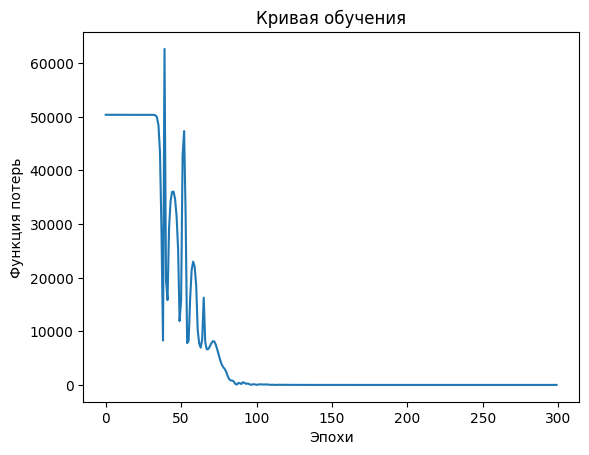

In [7]:
plt.plot(losses)
plt.title('Кривая обучения')
plt.xlabel('Эпохи')
plt.ylabel('Функция потерь')
plt.show()

# Тестирование модели

In [8]:
edge_index = torch.tensor([
  [0, 1, 2],
  [1, 2, 3]
], dtype=torch.long)

# Структура данных атрибутов вершин графа:
# Расход газа потребителя в узле, млн м3/сут; Давление газа, МПа
x = torch.tensor([[0, 7.4], [0.0, 0], [0, 0], [0, 5.4]], dtype=torch.float32)

# Структура данных атрибутов дуг графа:
# Протяженность, км; Внутренний диаметр трубы, мм
edge_attr = torch.tensor([
  [38, 1400],
  [40, 1400],
  [43, 1400]
])

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [12]:
%%time
# %%timeit 
# Attention: При выводе значений давления краевые значения не выводятся, но учитываются в расчете
P, flows, imbalance = model(data)
print(f'{P=}')
print(f'{flows=}')
print(f'{imbalance=}')

P=tensor([[1.5834],
        [6.6773],
        [6.0498],
        [1.6878]], grad_fn=<ReluBackward0>)
flows=tensor([[  0.0000],
        [104.8237],
        [ 90.5198],
        [ 84.2697]], grad_fn=<ScatterAddBackward0>)
imbalance=tensor([[-104.8237],
        [  14.3039],
        [   6.2501],
        [  84.2697]], grad_fn=<SubBackward0>)
CPU times: user 138 ms, sys: 28.4 ms, total: 166 ms
Wall time: 166 ms
